In [5]:
import pandas as pd
import json
import ast
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np
import gc

# This line is important to make tqdm work with pandas' apply function
tqdm.pandas()

file_path = 'crypto_merged.parquet'
df = pd.read_parquet(file_path)

nested_columns = ['chainTvls', 'tokens', 'tokensInUsd', 'tvl']
# protocols_df = df.drop(columns=nested_columns)

def extract_chain_tvl(row):
    try:
        chain_info = json.loads(row['chainTvls'])
        return [{
            "id": row['id'],
            "chain_name": chain_name,
            "date": tvl_entry['date'],
            "totalLiquidityUSD": tvl_entry['totalLiquidityUSD']
        } for chain_name, chain_data in chain_info.items() for tvl_entry in chain_data['tvl']]
    except Exception as e:
        print(f"Error in extract_chain_tvl for id {row['id']}: {e}")
        return [None]

# Define the function to apply
def extract_token_tvl(row):
    results = []
    try:
        # Parsing chainTvls
        chains_str = row['chainTvls']
        chains = {}
        if isinstance(chains_str, str):
            chains = json.loads(chains_str.replace('null', '0').replace('NULL', '0'))

        # Parsing tokens
        tokens_str = row['tokens']
        tokens_list = []
        if isinstance(tokens_str, str):
            tokens_list = ast.literal_eval(tokens_str.replace('null', '0').replace('NULL', '0'))

        # Parsing tokensInUsd and creating a lookup dictionary
        tokens_in_usd_str = row['tokensInUsd']
        tokens_in_usd_list = []
        if isinstance(tokens_in_usd_str, str):
            tokens_in_usd_list = ast.literal_eval(tokens_in_usd_str.replace('null', '0').replace('NULL', '0'))

        tokens_in_usd_dict = {item['date']: item['tokens'] for item in tokens_in_usd_list}

        for entry in tokens_list:
            date = entry['date']
            for chain_name, chain_data in chains.items():
                for token_name, quantity in entry['tokens'].items():
                    value_usd = tokens_in_usd_dict.get(date, {}).get(token_name, 0)
                    results.append([row['id'], chain_name, date, token_name, quantity, value_usd])
    except Exception as e:
        print(f"Error in extract_token_tvl for id {row['id']}: {e}")
        results.append([row['id'], None, None, None, None, None])
    return results

def extract_tvl(row):
    try:
        tvl_list = ast.literal_eval(row['tvl'].replace('null', '0').replace('NULL', '0'))
        return [[row['id'], entry['date'], entry['totalLiquidityUSD']] for entry in tvl_list]
    except Exception as e:
        print(f"Error in extract_tvl for id {row['id']}: {e}")
        return [[row['id'], None, None]]

# protocol_chain_tvl_data = df.progress_apply(extract_chain_tvl, axis=1).explode().dropna().tolist()
# protocol_chain_tvl_df = pd.DataFrame(protocol_chain_tvl_data)

protocol_token_tvl_data = df.progress_apply(extract_token_tvl, axis=1).explode().dropna().tolist()
del df
gc.collect()

protocol_token_tvl_df = pd.DataFrame(protocol_token_tvl_data, columns=['id', 'chain_name', 'date', 'token_name', 'quantity', 'value_usd'])

protocol_token_tvl_df.to_csv('protocol_token_tvl.csv', index=False)

100%|██████████| 3993/3993 [00:00<00:00, 15188.22it/s]

Error in extract_token_tvl for id 3777: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 2286: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 3732: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 240: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 2269: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 2: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 2275: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 2272: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Error in extract_token_tvl for id 3107: Expecting property name enclosed in 

In [6]:
import pandas as pd
import json
import glob

def extract_token_tvl_from_json_to_df(file_path):
    results = []
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        chains = data['chainTvls']
        tokens_list = data['tokens']
        tokens_in_usd_list = data['tokensInUsd']
        tokens_in_usd_dict = {item['date']: item['tokens'] for item in tokens_in_usd_list}
        for entry in tokens_list:
            date = entry['date']
            for chain_name, chain_data in chains.items():
                for token_name, quantity in entry['tokens'].items():
                    value_usd = tokens_in_usd_dict.get(date, {}).get(token_name, 0)
                    results.append([data['id'], chain_name, date, token_name, quantity, value_usd])
    except Exception as e:
        print(f"Error in extract_token_tvl: {e}")
        results.append([data.get('id', None), None, None, None, None, None])
    return pd.DataFrame(results, columns=['id', 'chain_name', 'date', 'token_name', 'quantity', 'value_usd'])

# Path to the llama folder containing JSON files
folder_path = 'data/llama/*.json'

# List all JSON files in the directory
json_files = glob.glob(folder_path)

# Process each JSON file and collect the resulting DataFrames
dfs = [extract_token_tvl_from_json_to_df(file) for file in json_files]

# Concatenate all DataFrames into one
unified_df = pd.concat(dfs, ignore_index=True)

# Now `unified_df` contains the combined data from all JSON files
print(unified_df)

ValueError: No objects to concatenate

         id chain_name        date token_name      quantity     value_usd
0      2276   Algorand  1668729600       OPUL  4.056403e+05  2.355472e+04
1      2276   Algorand  1668729600       USDC  2.631055e+06  2.628145e+06
2      2276   Algorand  1668729600       USDT  8.094955e+06  8.085524e+06
3      2276   Algorand  1668729600       ALGO  2.810422e+05  7.671917e+04
4      2276   Algorand  1668816000       OPUL  3.939969e+05  2.124825e+04
...     ...        ...         ...        ...           ...           ...
27814  2276   Ethereum  1709505659        MNT  6.744577e+05  6.029322e+05
27815  2276   Ethereum  1709505659       LOKA  1.016208e+05  3.671833e+04
27816  2276   Ethereum  1709505659       BORG  3.991289e+05  1.081176e+05
27817  2276   Ethereum  1709505659        WBT  5.112804e+05  4.218063e+06
27818  2276   Ethereum  1709505659       WETH  5.661644e+03  1.968978e+07

[27819 rows x 6 columns]


In [ ]:
import yaml
import requests

name = 'htx'

def load_config():
    with open("config.yaml", "r") as file:
        return yaml.safe_load(file)
    
config = load_config()

url = f"{config['base_url']}protocol/{name}"

def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    
data = fetch_data(url)

In [ ]:
import json 

def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

save_json(data, f'{name}.json')

In [ ]:
from json2html import *

html_table = json2html.convert(json = data)

In [ ]:
# Define the HTML file name
file_name = "json_table.html"

# Open the file in write mode and write the HTML table
with open(file_name, "w") as html_file:
    html_file.write(html_table)

print(f"The HTML table has been saved to {file_name}.")

The HTML table has been saved to json_table.html.


In [ ]:
chains = data['chainTvls']
tokens_list = data['tokens']
tokens_in_usd_list = data['tokensInUsd']
tokens_in_usd_dict = {item['date']: item['tokens'] for item in tokens_in_usd_list}

results = []
seen = set() 

for entry in tokens_list:
    date = entry['date']
    for chain_name, chain_data in chains.items():
        for token_name, quantity in entry['tokens'].items():
            identifier = (date, chain_name, token_name)
            if identifier not in seen:
                seen.add(identifier)
                value_usd = tokens_in_usd_dict.get(date, {}).get(token_name, 0)
                results.append([data['id'], chain_name, date, token_name, quantity, value_usd])

In [ ]:
import json
import pandas as pd
def extract_token_tvl(file_path, latest_date=None):
    results = []
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        chains = data['chainTvls']
        tokens_list = data['tokens']
        tokens_in_usd_list = data['tokensInUsd']
        tokens_in_usd_dict = {item['date']: item['tokens'] for item in tokens_in_usd_list}
        for entry in tokens_list:
            date = entry['date']
            """TODO: THIS SHOULD CHECK LATEST DATE FOR EACH UNIQUE CHAIN-TOKEN COMBINATION, 
            NOT JUST THE GLOBAL LATEST DATE FOR THE PROTOCOL."""
            if latest_date is not None and date <= latest_date:
                continue
            for chain_name, chain_data in chains.items():
                for token_name, quantity in entry['tokens'].items():
                    value_usd = tokens_in_usd_dict.get(date, {}).get(token_name, 0)
                    results.append([data['id'], chain_name, date, token_name, quantity, value_usd])
    except Exception as e:
        results.append([data.get('id', None), None, None, None, None, None])
    df = pd.DataFrame(results, columns=['id', 'chain_name', 'date', 'token_name', 'quantity', 'value_usd'])
    df['quantity'] = df['quantity'].astype('float64')
    df['value_usd'] = df['value_usd'].astype('float64')
    # if df.empty:
        # get_run_logger().info(f"No new data found in {file_path}.")
    return df

df = extract_token_tvl(f'{name}.json')

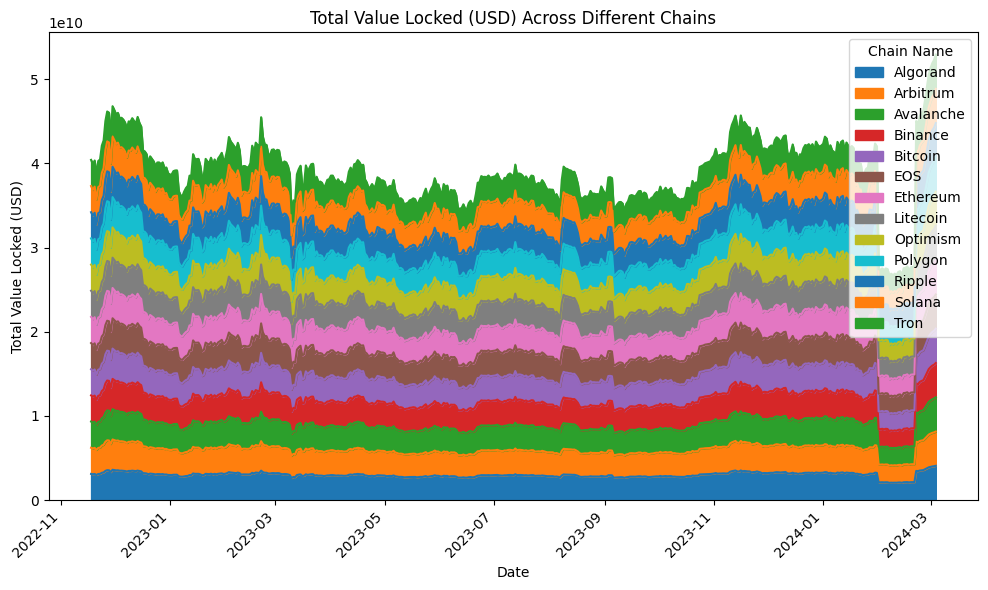

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Convert 'date' from UNIX timestamp to a readable date format
df['date'] = pd.to_datetime(df['date'], unit='s')

# Group by 'date' and 'chain_name', and sum 'value_usd'
grouped_df = df.groupby(['date', 'chain_name'])['value_usd'].sum().unstack(fill_value=0)

# Plotting
grouped_df.plot(kind='area', stacked=True, figsize=(10, 6))

plt.title('Total Value Locked (USD) Across Different Chains')
plt.xlabel('Date')
plt.ylabel('Total Value Locked (USD)')
plt.xticks(rotation=45)
plt.legend(title='Chain Name')
plt.tight_layout()
plt.show()

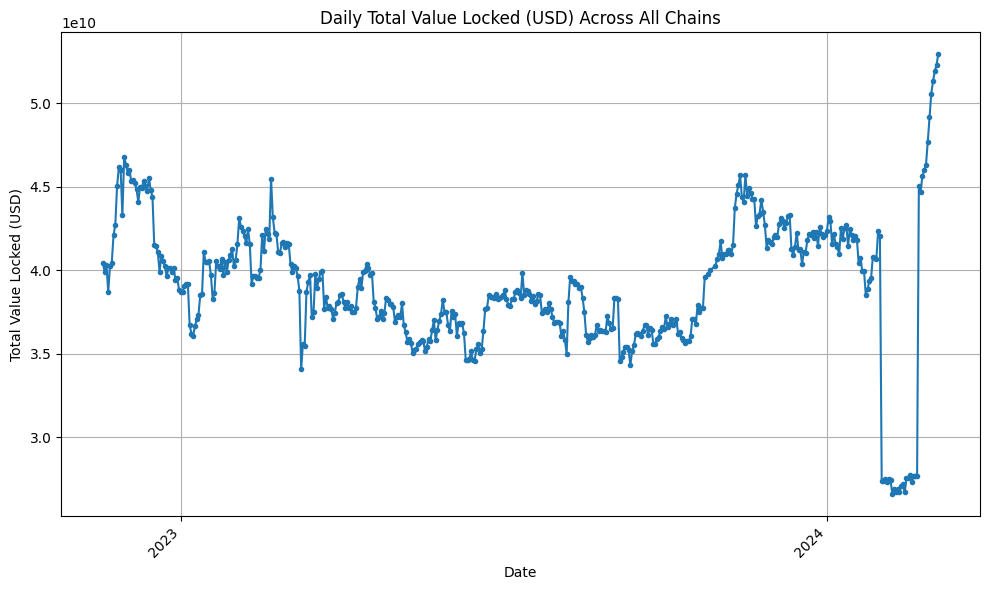

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df is your DataFrame
# Convert 'date' from UNIX timestamp to a readable date format
df['date'] = pd.to_datetime(df['date'], unit='s')

# Group by 'date' and sum 'value_usd' across all chains for each day
daily_sum_df = df.groupby('date')['value_usd'].sum()

# Plotting
daily_sum_df.plot(kind='line', figsize=(10, 6), marker='o', markersize=3)

plt.title('Daily Total Value Locked (USD) Across All Chains')
plt.xlabel('Date')
plt.ylabel('Total Value Locked (USD)')

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

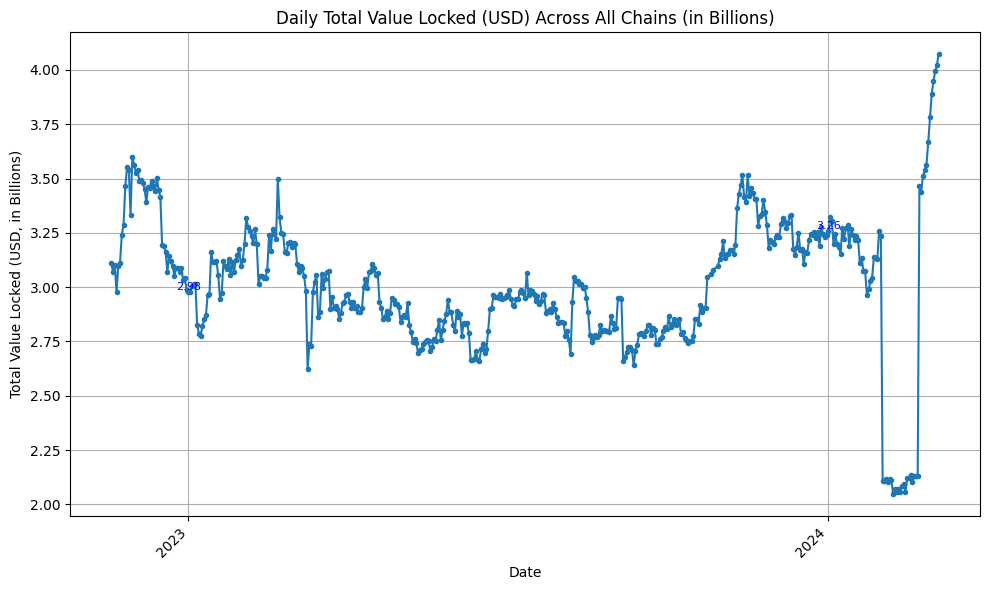

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df is your DataFrame
# Convert 'date' from UNIX timestamp to a readable date format
df['date'] = pd.to_datetime(df['date'], unit='s')

# Group by 'date' and sum 'value_usd' across all chains for each day
daily_sum_df = df.groupby('date')['value_usd'].sum()

# Convert 'value_usd' to billions for easier readability
daily_sum_df = daily_sum_df / 1e9

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
daily_sum_df.plot(kind='line', marker='o', markersize=3, ax=ax)

# Adding data point annotations at the start of each year
for x, y in zip(daily_sum_df.index, daily_sum_df):
    if x.month == 1 and x.day == 1:  # Check if the date is the start of a year
        ax.text(x, y, f'{y:.2f}', color='blue', fontsize=8, ha='center', va='bottom')

plt.title('Daily Total Value Locked (USD) Across All Chains (in Billions)')
plt.xlabel('Date')
plt.ylabel('Total Value Locked (USD, in Billions)')

# Set major ticks format
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
data.keys()

dict_keys(['id', 'name', 'url', 'description', 'logo', 'chains', 'gecko_id', 'cmcId', 'treasury', 'twitter', 'governanceID', 'wrongLiquidity', 'github', 'currentChainTvls', 'chainTvls', 'tokens', 'tokensInUsd', 'tvl', 'isParentProtocol', 'raises', 'metrics', 'symbol', 'mcap', 'otherProtocols', 'hallmarks'])

In [ ]:
data['tokensInUsd']

[{'date': 1668729600,
  'tokens': {'MATIC': 15706402.17862,
   'CRO': 31233.41343,
   'XCN': 88521138.49178,
   'CRV': 31845.75279,
   'SHIB': 17512141.69911,
   'GRT': 20636.9961,
   'USDT': 659270045.65315,
   'HT': 888202651.64078,
   'CHR': 24740.90242,
   'MASK': 84839.18,
   'AAVE': 161468.3512,
   'UNI': 1414156.608,
   'WBTC': 33639.22712,
   'CHZ': 187495.10254,
   'LINK': 6988745.85075,
   'MANA': 821385.64651,
   'WETH': 159146756.22142,
   'DAI': 173180.48866,
   '1INCH': 54136.65915,
   'SOL': 3089897.17468,
   'TUSD': 375044.01345,
   'MKR': 22883.4688,
   'USDC': 75516940.70362,
   'LRC': 32391.91375,
   'OPUL': 23554.72288,
   'EOS': 9924961.33496,
   'SUSHI': 203864.751,
   'AVAX': 368049.39923,
   'LTC': 13257362.40891,
   'TRX': 442903706.0804,
   'BTC': 725683473.04453,
   'ALGO': 76719.17317}},
 {'date': 1668816000,
  'tokens': {'MATIC': 19037433.8037,
   'CRO': 32178.04795,
   'XCN': 95864400.53258,
   'CRV': 31526.73437,
   'SHIB': 17327697.19178,
   'GRT': 20287

In [ ]:
data['chainTvls']['Algorand']['tokensInUsd']

[{'date': 1668729600,
  'tokens': {'OPUL': 23554.72288,
   'USDC': 2628145.44187,
   'USDT': 8085524.37961,
   'ALGO': 76719.17317}},
 {'date': 1668816000,
  'tokens': {'OPUL': 21248.25346,
   'USDC': 2679908.14094,
   'USDT': 8669220.46983,
   'ALGO': 87953.31686}},
 {'date': 1668902400,
  'tokens': {'OPUL': 23037.38347,
   'USDC': 2579434.00484,
   'USDT': 9700808.74828,
   'ALGO': 81818.24263}},
 {'date': 1668988800,
  'tokens': {'OPUL': 20040.63805,
   'USDC': 2656613.18102,
   'USDT': 9603137.69829,
   'ALGO': 72589.84901}},
 {'date': 1669075200,
  'tokens': {'OPUL': 18422.08047,
   'USDC': 1550382.66232,
   'USDT': 10172102.03225,
   'ALGO': 68579.51263}},
 {'date': 1669161600,
  'tokens': {'OPUL': 20719.29166,
   'USDC': 867803.21923,
   'USDT': 10641020.72983,
   'ALGO': 67331.28739}},
 {'date': 1669248000,
  'tokens': {'OPUL': 21203.93187,
   'USDC': 253770.73959,
   'USDT': 10651740.62301,
   'ALGO': 69161.51061}},
 {'date': 1669334400,
  'tokens': {'OPUL': 21538.05443,
   'U

In [ ]:
data['chainTvls']['Ethereum']['tokensInUsd']

[{'date': 1668729600,
  'tokens': {'CRO': 31233.41343,
   'MATIC': 218759.75862,
   'XCN': 88521138.49178,
   'CRV': 31845.75279,
   'SHIB': 17512141.69911,
   'GRT': 20636.9961,
   'USDT': 583635023.20885,
   'HT': 888202651.64078,
   'CHR': 24740.90242,
   'MASK': 84839.18,
   'AAVE': 161468.3512,
   'UNI': 1414156.608,
   'WBTC': 33639.22712,
   'CHZ': 187495.10254,
   'LINK': 6988745.85075,
   'MANA': 821385.64651,
   'WETH': 159146756.22142,
   'DAI': 173180.48866,
   '1INCH': 54136.65915,
   'TUSD': 375044.01345,
   'MKR': 22883.4688,
   'USDC': 42627051.56267,
   'LRC': 32391.91375,
   'SUSHI': 203864.751}},
 {'date': 1668816000,
  'tokens': {'MATIC': 215776.00909,
   'CRO': 32178.04795,
   'XCN': 95864400.53258,
   'CRV': 31526.73437,
   'SHIB': 17327697.19178,
   'GRT': 20287.68855,
   'USDT': 585981475.13789,
   'CHR': 24718.45636,
   'HT': 861450768.84488,
   'MASK': 79848.64,
   'AAVE': 157944.0252,
   'UNI': 1433797.672,
   'WBTC': 33395.84914,
   'CHZ': 214890.63024,
   '

In [ ]:
import pandas as pd

def extract_token_tvl(file_path, latest_date=None):
    results = []
    with open(file_path, 'r') as f:
        data = json.load(f)

    for chain_name, chain_data in data['chainTvls'].items():
        tokens_usd = chain_data['tokensInUsd']
        tokens_quantity = chain_data['tokens']

        for usd_entry, quantity_entry in zip(tokens_usd, tokens_quantity):
            date = usd_entry['date']
            if latest_date is not None and date <= latest_date:
                continue
            for token_name, value_usd in usd_entry['tokens'].items():
                quantity = quantity_entry['tokens'].get(token_name, 0)
                results.append([data['id'], chain_name, date, token_name, quantity, value_usd])

    df = pd.DataFrame(results, columns=['id', 'chain_name', 'date', 'token_name', 'quantity', 'value_usd'])
    df['quantity'] = df['quantity'].astype('float64')
    df['value_usd'] = df['value_usd'].astype('float64')
    return df

df = extract_token_tvl(f'{name}.json')

In [ ]:
from collections import defaultdict

# Initialize a dictionary to hold the sum of USD values for all tokens on each date
date_values_sum = defaultdict(float)

# Iterate through each entry in the data['tokensInUsd']
for entry in data['tokensInUsd']:
    date = entry['date']
    tokens = entry['tokens']
    for value_usd in tokens.values():
        # Sum the value_usd for all tokens on this date
        date_values_sum[date] += value_usd

# Convert the defaultdict to a regular dict for easier viewing or further processing
date_values_sum = dict(date_values_sum)

# Print the aggregated values for each date
for date, total_value in date_values_sum.items():
    print(f"Date {date}: Total USD Value {total_value}")

Date 1668729600: Total USD Value 3109865488.2529097
Date 1668816000: Total USD Value 3070639285.2816896
Date 1668902400: Total USD Value 3104138875.07243
Date 1668988800: Total USD Value 2977666513.92375
Date 1669075200: Total USD Value 3099312486.807199
Date 1669161600: Total USD Value 3113256041.1400204
Date 1669248000: Total USD Value 3239587753.4342504
Date 1669334400: Total USD Value 3287260202.61347
Date 1669420800: Total USD Value 3465107610.5932193
Date 1669507200: Total USD Value 3552093493.5481205
Date 1669593600: Total USD Value 3541679423.593171
Date 1669680000: Total USD Value 3330521953.2507296
Date 1669766400: Total USD Value 3600598694.6322193
Date 1669852800: Total USD Value 3564723616.6828103
Date 1669939200: Total USD Value 3525949193.3891397
Date 1670025600: Total USD Value 3539590861.8343906
Date 1670112000: Total USD Value 3487574322.1284113
Date 1670198400: Total USD Value 3494791361.3365784
Date 1670284800: Total USD Value 3478414058.8088307
Date 1670371200: Tot

In [1]:
from config.query import BigQueryClient, MotherduckClient

bq, md = BigQueryClient(), MotherduckClient()

# md.compare_months('2023','12','2024','01')

In [2]:
md.get_protocol_data('MakerDAO','yearly')

,aggregated_date,id,protocol_name,category,type,chain_name,token_name,avg_total_quantity,avg_total_value_usd
0,2022-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,ADAI,1.790765e+09,1.797232e+09
1,2022-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,DAI-WBTC-UNI-V2,7.440000e-03,2.273974e+05
2,2022-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,WBTC,9.311934e+06,2.009037e+11
3,2022-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,MANA,1.291744e+10,1.070081e+10
4,2022-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,LRC,1.663050e+07,5.866895e+06
...,...,...,...,...,...,...,...,...,...
80,2024-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,BAT,6.728614e+06,1.630842e+06
81,2024-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,USDP,5.177547e+09,5.177514e+09
82,2024-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,LINK,2.798538e+06,4.740470e+07
83,2024-01-01,118,MakerDAO,CDP,"Lending, Borrowing & Real World Assets",Ethereum,ZRX,3.229180e+06,1.080841e+06


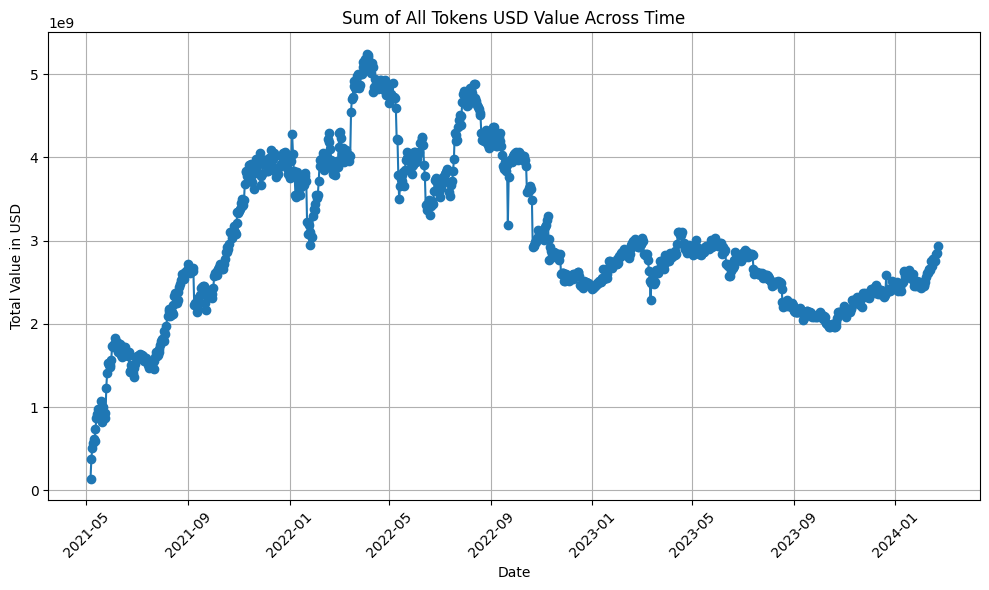

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = md.get_protocol_data('Uniswap V3', 'daily')

# Aggregate the average total USD value across all tokens for each aggregated_date
agg_df = df.groupby('aggregated_date')['avg_total_value_usd'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(agg_df['aggregated_date'], agg_df['avg_total_value_usd'], marker='o', linestyle='-')
plt.title('Sum of All Tokens USD Value Across Time')
plt.xlabel('Date')
plt.ylabel('Total Value in USD')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()